<a href="https://colab.research.google.com/github/roshancharlie/Hindi-To-English-Transliteration-Model/blob/main/Transliteration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
pip install keras


[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [32]:
pip install tensorflow

^C
ERROR: Operation cancelled by user
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install numpy


[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install pandas


[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


#Importing the Libraries

In [ ]:
import pandas as pd
import json
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, LSTM, Dense,Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
import numpy as np

2024-08-11 22:33:09.561494: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Data Preparation

In [87]:
train = pd.read_csv('transliterated_words.csv')
for lines in train:
        print(lines)
print(train.columns)

train.head()

Hindi
Transliteration
Index(['Hindi', 'Transliteration'], dtype='object')


,Hindi,Transliteration
0,श्वाघ्निक,shvāghnik
1,प्लॉट,plŏṭ
2,प्लॉटों,plŏṭôn
3,परिहारण,parihāraṇ
4,अपरिहारण,aparihāraṇ


In [88]:
train['Hindi'] = train['Hindi'].astype(str)
train['Transliteration'] = train['Transliteration'].astype(str)

In [89]:
train['Hindi'] = train['Hindi'].str.strip() # hindi has no caps
train['Transliteration'] = train['Transliteration'].str.strip().str.lower()
for lines in train:
        print(lines)

Hindi
Transliteration


In [90]:
train = train[~train['Transliteration'].str.contains('\.')]
train = train[~train['Transliteration'].str.contains(',')]
for lines in train:
        print(lines)

Hindi
Transliteration


In [92]:
train.head()


,Hindi,Transliteration
0,श्वाघ्निक,shvāghnik
1,प्लॉट,plŏṭ
2,प्लॉटों,plŏṭôn
3,परिहारण,parihāraṇ
4,अपरिहारण,aparihāraṇ


In [93]:
def isEnglish(s):
  try:
      s.encode(encoding='utf-8').decode('ascii')
  except UnicodeDecodeError:
      return False
  else:
      return True

train = train[train['Transliteration'].apply(isEnglish)]

In [94]:
sos = '^'
eos = '$'

train['Transliteration'] = sos + train['Transliteration'].astype(str) + eos

train.tail()

,Hindi,Transliteration
8602,धमनि,^dhamani$
8606,शहबुलबुल,^shahabulabul$
8627,जगतिओं,^jagation$
8657,इन्क,^enk$
8674,जगत्,^jagat$


In [95]:
hindi_text = train['Hindi']
english_text = train['Transliteration']
print(hindi_text)
print(english_text)

5        लघुक्रम
48        ज़िपलौक
60         नरभुक
75       दुभिक्ष
78       मृदंगफल
          ...   
8602        धमनि
8606    शहबुलबुल
8627      जगतिओं
8657        इन्क
8674        जगत्
Name: Hindi, Length: 754, dtype: object
5          ^lgahukram$
48           ^ipalauk$
60          ^narbahuk$
75         ^dubhikshh$
78        ^mridngafal$
             ...      
8602         ^dhamani$
8606    ^shahabulabul$
8627        ^jagation$
8657             ^enk$
8674           ^jagat$
Name: Transliteration, Length: 754, dtype: object


In [96]:
print('hindi text shape :',hindi_text.shape)
print(hindi_text.iloc[0])
print('english text shape :',english_text.shape)
print(english_text.iloc[0])

hindi text shape : (754,)
लघुक्रम
english text shape : (754,)
^lgahukram$


In [97]:
train_hindi_text, val_hindi_text, train_english_text, val_english_text = train_test_split(hindi_text, english_text, test_size=0.2, random_state=42)

In [98]:
max_input_len = max([len(text) for text in hindi_text])
print(max_input_len)
max_target_len = max([len(text) for text in english_text])
print(max_target_len)

17
19


In [99]:
input_chars = sorted(list(set(''.join(hindi_text))))
print(input_chars)
target_chars = sorted(list(set(''.join(english_text))))
print(target_chars)

['-', 'ं', 'अ', 'आ', 'इ', 'ई', 'उ', 'ऊ', 'ए', 'ऐ', 'ऑ', 'ओ', 'औ', 'क', 'ख', 'ग', 'घ', 'च', 'छ', 'ज', 'झ', 'त', 'थ', 'द', 'ध', 'न', 'प', 'फ', 'ब', 'भ', 'म', 'य', 'र', 'ल', 'व', 'श', 'ष', 'ह', '़', 'ि', 'ु', 'ृ', 'ै', 'ौ', '्', 'क़', 'ख़', 'ग़', 'ज़', 'ड़', 'ढ़', 'फ़', '॰', '\u200c']
['$', '^', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'y']


In [100]:
num_encoder_tokens = len(input_chars)
print(num_encoder_tokens)
num_decoder_tokens = len(target_chars)
print(num_encoder_tokens)

54
54


In [101]:
input_char_index = dict((char, i) for i, char in enumerate(input_chars))
print(input_char_index)
target_char_index = dict((char, i) for i, char in enumerate(target_chars))
print(target_char_index)

{'-': 0, 'ं': 1, 'अ': 2, 'आ': 3, 'इ': 4, 'ई': 5, 'उ': 6, 'ऊ': 7, 'ए': 8, 'ऐ': 9, 'ऑ': 10, 'ओ': 11, 'औ': 12, 'क': 13, 'ख': 14, 'ग': 15, 'घ': 16, 'च': 17, 'छ': 18, 'ज': 19, 'झ': 20, 'त': 21, 'थ': 22, 'द': 23, 'ध': 24, 'न': 25, 'प': 26, 'फ': 27, 'ब': 28, 'भ': 29, 'म': 30, 'य': 31, 'र': 32, 'ल': 33, 'व': 34, 'श': 35, 'ष': 36, 'ह': 37, '़': 38, 'ि': 39, 'ु': 40, 'ृ': 41, 'ै': 42, 'ौ': 43, '्': 44, 'क़': 45, 'ख़': 46, 'ग़': 47, 'ज़': 48, 'ड़': 49, 'ढ़': 50, 'फ़': 51, '॰': 52, '\u200c': 53}
{'$': 0, '^': 1, 'a': 2, 'b': 3, 'c': 4, 'd': 5, 'e': 6, 'f': 7, 'g': 8, 'h': 9, 'i': 10, 'j': 11, 'k': 12, 'l': 13, 'm': 14, 'n': 15, 'o': 16, 'p': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'y': 24}


In [102]:
encoder_input_data = np.zeros((len(train_hindi_text), max_input_len, num_encoder_tokens), dtype='float32')
decoder_input_data = np.zeros((len(train_english_text), max_target_len, num_decoder_tokens), dtype='float32')
decoder_target_data = np.zeros((len(train_english_text), max_target_len, num_decoder_tokens), dtype='float32')

In [103]:
for i, (input_text, target_text) in enumerate(zip(train_hindi_text, train_english_text)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_char_index[char]] = 1
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, target_char_index[char]] = 1
        if t > 0:
            decoder_target_data[i, t - 1, target_char_index[char]] = 1

# Defining The Model

In [104]:
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(256, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]


decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [105]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Model Training

In [107]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks for early stopping and model checkpoint
model_save_filename = "model.keras"
earlystopping_cb = EarlyStopping(
    monitor="val_accuracy",
    mode="max",
    verbose=1,
    patience=20,
    restore_best_weights=True
)
mdlcheckpoint_cb = ModelCheckpoint(
    model_save_filename,
    monitor="val_accuracy",
    mode="max",
    verbose=1,
    save_best_only=True
)

# Print the summary of the model
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, None, 54)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, None, 25)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 256),     │    318,464 │ input_layer_4[0]… │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, None,     │    288,768 │ input_layer_5[0]… │
│                     │ 256), (None,      │            │ lstm_2[0][1],     │
│                     │ 256), (None,      │            │ lstm_2[0][2]      │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, None, 25)  │      6,425 │ lstm_3[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 613,657 (2.34 MB)

 Trainable params: 613,657 (2.34 MB)

 Non-trainable params: 0 (0.00 B)

In [109]:
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=64,
          epochs=50,
          validation_split=0.2, 
          callbacks=[earlystopping_cb, mdlcheckpoint_cb])

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.5060 - loss: 1.2083
Epoch 1: val_accuracy did not improve from 0.68247
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 396ms/step - accuracy: 0.4857 - loss: 1.2110 - val_accuracy: 0.0826 - val_loss: 1.1751
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.0882 - loss: 1.2041
Epoch 2: val_accuracy did not improve from 0.68247
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 354ms/step - accuracy: 0.0885 - loss: 1.2050 - val_accuracy: 0.0826 - val_loss: 1.1588
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.2823 - loss: 1.2123
Epoch 3: val_accuracy did not improve from 0.68247
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 392ms/step - accuracy: 0.2892 - loss: 1.2100 - val_accuracy: 0.0826 - val_loss: 1.1465
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.0892 - loss: 1.1903
Epoch 4: val_accuracy did not improve from 0.68247
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 346ms/step - accuracy: 0.0894 - loss: 1.1895 - val_accuracy: 0.0826 - val_loss: 1.1444


In [110]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


In [ ]:
pip install matplotlib

^C
Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pip/__main__.py", line 29, in <module>
    from pip._internal.cli.main import main as _main
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pip/_internal/__init__.py", line 3, in <module>
    import pip._internal.utils.inject_securetransport  # noqa
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pip/_internal/utils/inject_securetransport.py", line 35, in <module>
    inject_securetransport()
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pip/_internal/utils/inject_securetransport.py", line 19, in inject_securetransport
    import ssl
  File "/Library/Frameworks/Python.framework/Versions

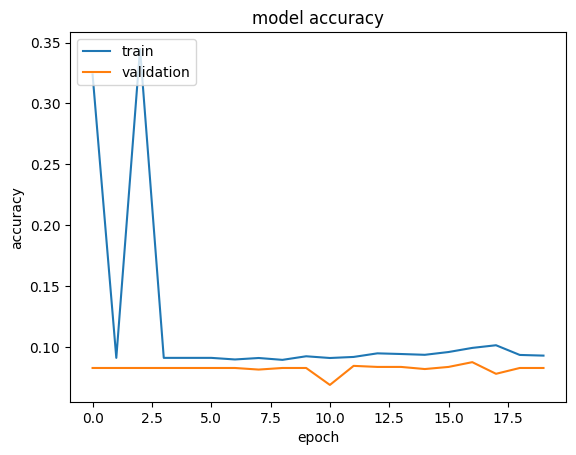

In [111]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

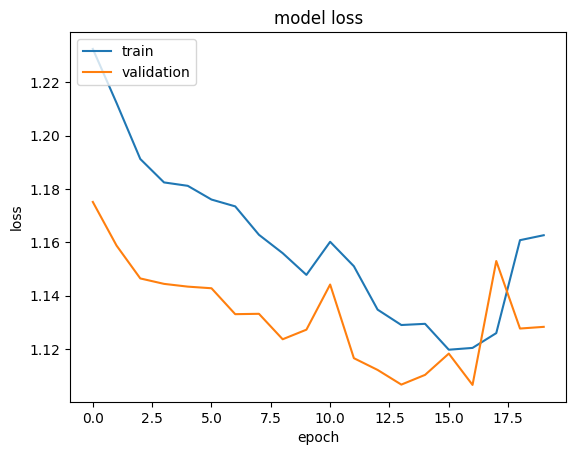

In [112]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Model Inference

In [113]:
model = load_model('model.keras')

In [114]:
val_encoder_input_data = np.zeros((len(val_hindi_text), max_input_len, num_encoder_tokens), dtype='float32')
val_decoder_input_data = np.zeros((len(val_english_text), max_target_len, num_decoder_tokens), dtype='float32')
val_decoder_target_data = np.zeros((len(val_english_text), max_target_len, num_decoder_tokens), dtype='float32')

In [115]:
for i, (input_text, target_text) in enumerate(zip(val_hindi_text, val_english_text)):
    for t, char in enumerate(input_text):
        val_encoder_input_data[i, t, input_char_index[char]] = 1
    for t, char in enumerate(target_text):
        val_decoder_input_data[i, t, target_char_index[char]] = 1
        if t > 0:
            val_decoder_target_data[i, t - 1, target_char_index[char]] = 1

In [116]:
scores = model.evaluate([val_encoder_input_data, val_decoder_input_data], val_decoder_target_data, verbose=1)
print('Val loss:', scores[0])
print('Val accuracy:', scores[1])

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.6620 - loss: 1.2724
Val loss: 1.2772080898284912
Val accuracy: 0.6612060070037842


In [117]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(256,))
decoder_state_input_c = Input(shape=(256,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

In [118]:
reverse_input_char_index = dict((i, char) for char, i in input_char_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_char_index.items())

In [120]:
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, target_char_index['^']] = 1.0
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = target_chars[sampled_token_index]
        decoded_sentence += sampled_char
        if (sampled_char == '$' or len(decoded_sentence) > max_target_len):
            stop_condition = True
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0
        states_value = [h, c]
    return decoded_sentence

In [121]:
def predict_output(input_text):
    words = input_text.split(' ')
    transliterated_words = []
    for word in words:
        input_seq = np.zeros((1, max_input_len, num_encoder_tokens), dtype='float32')
        for t, char in enumerate(word):
            if char in input_char_index:
                input_seq[0, t, input_char_index[char]] = 1
            else:
                print(f"Warning: Character '{char}' not found in input_char_index.")
                # Optionally handle the missing character here (e.g., use a placeholder index)
        decoded_word = decode_sequence(input_seq)
        transliterated_words.append(decoded_word.rstrip('$'))
    return ' '.join(transliterated_words)


In [122]:
text = 'शब्दावली'
print('Hindi text:',text)
print('Transliterated English text:',predict_output(text))

Hindi text: शब्दावली
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Transliterated English text: aaaaaaaaaaaaaaaaaaaa


In [123]:
text = 'क्या है'
print('Hindi text:',text)
print('Transliterated English text:',predict_output(text))
#kya haai

Hindi text: क्या है
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [124]:
text = 'रोशन'
print('Hindi text:',text)
print('Transliterated English text:',predict_output(text))

Hindi text: रोशन
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Transliterated English text: aaaaaaaaaaaaaaaaaaaa


In [125]:
text = 'अनुवाद'
print('Hindi text:',text)
print('Transliterated English text:',predict_output(text))

Hindi text: अनुवाद
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Transliterated English text: aaaaaaaaaaaaaaaaaaaa


In [81]:
import os
print(os.getcwd())

/Users/mjere/Downloads/UROP


In [80]:
model.save('/Users/mjere/Downloads/UROP/model.keras')